In [1]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer,Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization,Resizing, Rescaling
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast, RandomZoom, GaussianNoise
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy



In [2]:
import tensorflow_probability as tfp


In [3]:
train_directory="C:/Users/tarik/Downloads/Teeth DataSet/Teeth_Dataset/Training"
validation_directory="C:/Users/tarik/Downloads/Teeth DataSet/Teeth_Dataset/Validation"
test_directory="C:/Users/tarik/Downloads/Teeth DataSet/Teeth_Dataset/Testing"


In [36]:
CLASS_NAMES=['CaS','CoS','Gum','MC','OC','OLP','OT']

CONFIGURATION= {
    "BATCH_SIZE": 16,
    "IM_SIZE": 256,
    "LEARNING_RATE":0.001,
    "N_EPOCHS":20,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":100,
    "N_DENSE_2":10,
    "NUM_CLASSES":7,
    
}

In [37]:
train_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical', # ex: 0,0,1 called one-hot encoding
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99, #Spicified it to alweys same shuffling
    validation_split=None,
    
)

Found 3087 files belonging to 7 classes.


In [38]:
validation_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical', # ex: 0,0,1 called one-hot encoding
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99, #Spicified it to alweys same shuffling
    
)

Found 1028 files belonging to 7 classes.


In [39]:
test_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical', # ex: (0,0,1) called one-hot encoding, many traditional neural network architectures are designed to work with one-hot encoded vectors.
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99, #Spicified it to alweys same shuffling
    
)

Found 1028 files belonging to 7 classes.


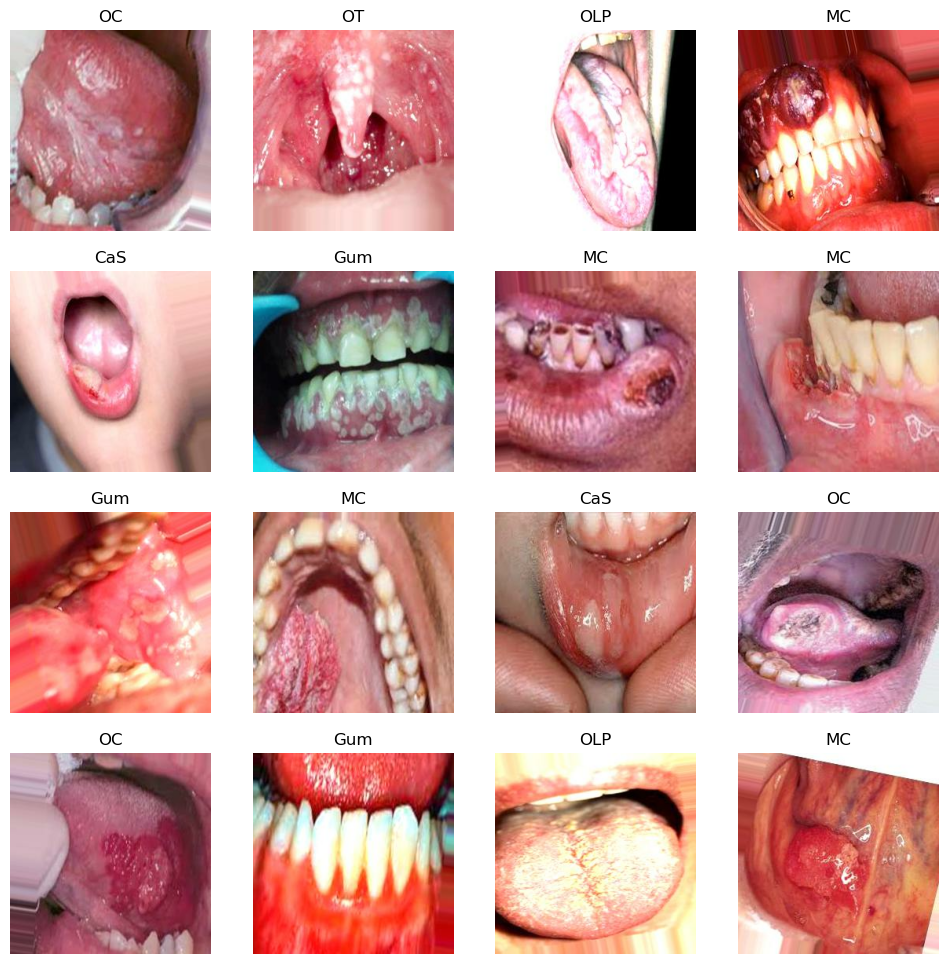

In [40]:
plt.figure(figsize=(12,12))
for images, labels in train_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
        plt.axis("off")

In [41]:
def box(lamda):
    r_x=tf.cast(tfp.distributions.Uniform(0,CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
    r_y=tf.cast(tfp.distributions.Uniform(0,CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

    r_w = tf.cast(CONFIGURATION["IM_SIZE"] * tf.math.sqrt(1-lamda), dtype= tf.int32)
    r_h = tf.cast(CONFIGURATION["IM_SIZE"] * tf.math.sqrt(1-lamda), dtype= tf.int32)

    r_x = tf.clip_by_value( r_x - r_w//2, 0 , CONFIGURATION["IM_SIZE"])
    r_y = tf.clip_by_value( r_y - r_h//2, 0 , CONFIGURATION["IM_SIZE"])

    x_b_r = tf.clip_by_value( r_x + r_w//2, 0 , CONFIGURATION["IM_SIZE"])
    y_b_r = tf.clip_by_value( r_y + r_h//2, 0 , CONFIGURATION["IM_SIZE"])

    r_w = x_b_r - r_x
    r_h = y_b_r - r_y

    if(r_w==0):
        r_w=1

    r_h = y_b_r - r_y 
    if(r_h==0):
        r_h=1

    return r_x,r_y,r_w,r_h






In [42]:
def cutmix(train_dataset_1,train_dataset_2):
    
    image_1, label_1 = train_dataset_1
    image_2, label_2 = train_dataset_2
    
    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda=lamda.sample(1)[0]
    r_y, r_x, r_h, r_w= box(lamda)
    crop_1=tf.image.crop_to_bounding_box(image_1,r_y,r_x,r_h,r_w)
    pad_1= tf.image.pad_to_bounding_box(crop_1,r_y,r_x,CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"])

    crop_2=tf.image.crop_to_bounding_box(image_2,r_y,r_x,r_h,r_w)
    pad_2= tf.image.pad_to_bounding_box(crop_2,r_y,r_x,CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"])
    
    image=image_1-pad_1 + pad_2
    lamda= tf.cast( (r_w * r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype=tf.float32)
    label=lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)
    
    return image,label




    

In [43]:
augment_layers= tf.keras.Sequential([
    RandomRotation((-0.025, 0.025)),
    GaussianNoise(0.1),  
    RandomContrast(factor=0.2),
    RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),

])

def augment_layer(image,label):
    return augment_layers(image,training=True),label

In [44]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1,train_dataset_2))

In [45]:
training_dataset=(    
mixed_dataset
.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
.prefetch(tf.data.AUTOTUNE)
) 



In [46]:
val_datset=(
validation_dataset
.prefetch(tf.data.AUTOTUNE)
)


In [47]:
testing_datset=(
test_dataset
.prefetch(tf.data.AUTOTUNE)
)


In [48]:
from tensorflow.keras.layers import LeakyReLU

model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255, name="rescaling"),

    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid', 
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters=CONFIGURATION["N_FILTERS"] * 2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid', 
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"] * 2, kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),

    Dense(CONFIGURATION["N_DENSE_2"] * 2, kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),
])
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_7 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 254, 254, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 125, 125, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 200)            │    12,301,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 20)             │         4,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 7)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,307,183 (46.95 MB)

 Trainable params: 12,306,699 (46.95 MB)

 Non-trainable params: 484 (1.89 KB)

In [49]:
loss_function=CategoricalCrossentropy(from_logits=False)
metrics=[CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]
model.compile(
   optimizer=Adam(learning_rate= CONFIGURATION["LEARNING_RATE"]),
   loss=loss_function,
   metrics=metrics


)
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the model with early stopping
history = model.fit(
    training_dataset,
    validation_data=val_datset,
    epochs=80,
    verbose=1,
)

Epoch 1/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 76s 355ms/step - accuracy: 0.1450 - loss: 2.2394 - top_k_accuracy: 0.2953 - val_accuracy: 0.1663 - val_loss: 1.9330 - val_top_k_accuracy: 0.3191
Epoch 2/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 72s 368ms/step - accuracy: 0.1449 - loss: 1.9854 - top_k_accuracy: 0.2943 - val_accuracy: 0.2461 - val_loss: 1.8774 - val_top_k_accuracy: 0.4241
Epoch 3/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 72s 365ms/step - accuracy: 0.1680 - loss: 1.9490 - top_k_accuracy: 0.3387 - val_accuracy: 0.2831 - val_loss: 1.8267 - val_top_k_accuracy: 0.5000
Epoch 4/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 76s 387ms/step - accuracy: 0.1706 - loss: 1.9400 - top_k_accuracy: 0.3332 - val_accuracy: 0.2558 - val_loss: 1.8307 - val_top_k_accuracy: 0.4893
Epoch 5/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 82s 416ms/step - accuracy: 0.1904 - loss: 1.9222 - top_k_accuracy: 0.3609 - val_accuracy: 0.2772 - val_loss: 1.8329 - val_top_k_accuracy: 0.4669
Epoch 6/80
193/193 ━━━━━━━━━━━━━━━━━━━━ 80s 407ms/step - accuracy: 0.1878 -

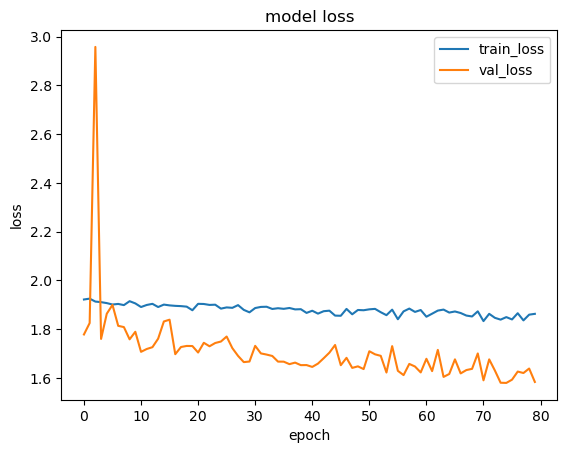

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

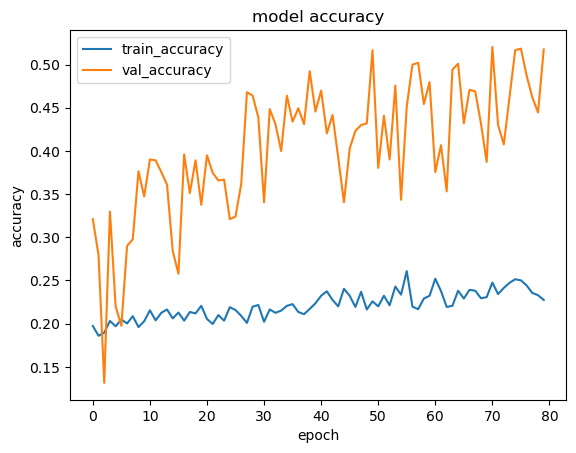

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()